# File and libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


filepath=r'data/df_merch_4_outlier_input.csv'


file_tag = "df_merch_scaling_input"

# DSLabs functions

In [21]:
%run "scripts/dslabs_functions.py"


# Data functions

In [22]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [23]:
# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    data=pd.read_csv(filepath)

    # 1% sample
    data=data.sample(frac=0.01, replace=False)
    

else:
    data=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

 
target='returning_user'
vars: list[str] = data.columns.to_list()


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364427 entries, 0 to 364426
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   event_name                       364427 non-null  float64
 1   device_category                  364427 non-null  float64
 2   device_mobile_brand_name         364427 non-null  float64
 3   device_mobile_model_name         364427 non-null  float64
 4   device_operating_system          364427 non-null  float64
 5   device_operating_system_version  364427 non-null  float64
 6   device_language                  364427 non-null  float64
 7   device_web_info_browser          364427 non-null  float64
 8   device_web_info_browser_version  364427 non-null  float64
 9   geo_region                       364427 non-null  float64
 10  geo_city                         364427 non-null  float64
 11  traffic_source_medium            364427 non-null  float64
 12  traffic

# Scale 1 - Standard Scaler

## Scale 1 strategy Application

In [24]:

def apply_strategy_1(df):

    df_copy=df.copy()
    
    df_zscore=apply_standard_scaler(df_copy,target)

    return df_zscore


data_1=apply_strategy_1(data)

data_1.columns


Index(['event_name', 'device_category', 'device_mobile_brand_name',
       'device_mobile_model_name', 'device_operating_system',
       'device_operating_system_version', 'device_language',
       'device_web_info_browser', 'device_web_info_browser_version',
       'geo_region', 'geo_city', 'traffic_source_medium',
       'traffic_source_source', 'engagement_time_msec', 'month', 'day_of_year',
       'week_number', 'page_path_level_1', 'page_path_level_2',
       'page_path_level_3', 'path_length', 'time_of_day_sin',
       'time_of_day_cos', 'local_hour_sin', 'local_hour_cos',
       'local_minute_sin', 'local_minute_cos', 'hour_minute_fraction_sin',
       'hour_minute_fraction_cos', 'day_sin', 'day_cos', 'day_of_week_nr_sin',
       'day_of_week_nr_cos', 'week_of_month_nr_sin', 'week_of_month_nr_cos',
       'geo_country', 'session_engaged', 'year', 'quarter', 'is_weekend',
       'domain', 'returning_user'],
      dtype='object')

## Scale 1 train/test split 

Labels=[0.0, 1.0]


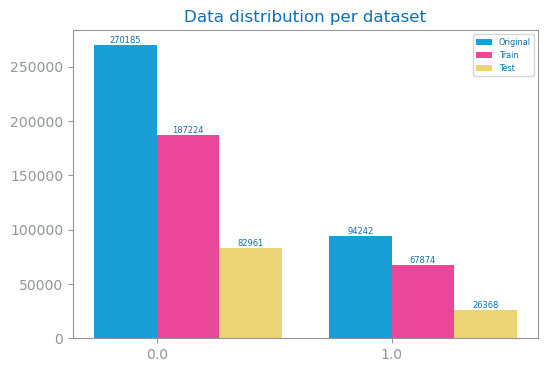

In [25]:
if evaluate ==True:
    
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart


    # Call the function to split the data
    y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)

    train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)


    # Distribution check
    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Scale 1 evaluate

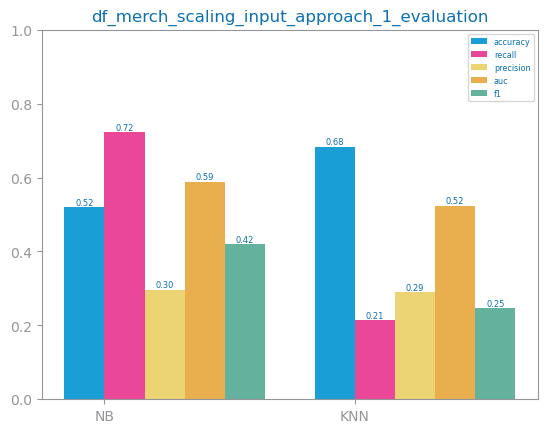

In [26]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values
if evaluate == True:
    
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='returning_user', metric="precision")
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_1_evaluation.png")
    show()

# Scale 2 - MinMax Scaler


## Scale 2 strategy aplication

In [27]:
from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler



def apply_strategy_2(df):

    df_copy=df.copy()
    
    # this script is available in data_functions originally from DSLabs site in Scaling chapter
    df_copy=apply_min_max_scaler(df,target)

    return df_copy

data_2=apply_strategy_2(data)
data_2.columns

Index(['event_name', 'device_category', 'device_mobile_brand_name',
       'device_mobile_model_name', 'device_operating_system',
       'device_operating_system_version', 'device_language',
       'device_web_info_browser', 'device_web_info_browser_version',
       'geo_region', 'geo_city', 'traffic_source_medium',
       'traffic_source_source', 'engagement_time_msec', 'month', 'day_of_year',
       'week_number', 'page_path_level_1', 'page_path_level_2',
       'page_path_level_3', 'path_length', 'time_of_day_sin',
       'time_of_day_cos', 'local_hour_sin', 'local_hour_cos',
       'local_minute_sin', 'local_minute_cos', 'hour_minute_fraction_sin',
       'hour_minute_fraction_cos', 'day_sin', 'day_cos', 'day_of_week_nr_sin',
       'day_of_week_nr_cos', 'week_of_month_nr_sin', 'week_of_month_nr_cos',
       'geo_country', 'session_engaged', 'year', 'quarter', 'is_weekend',
       'domain', 'returning_user'],
      dtype='object')

## Scale 2 train/test split 

Labels=[0.0, 1.0]


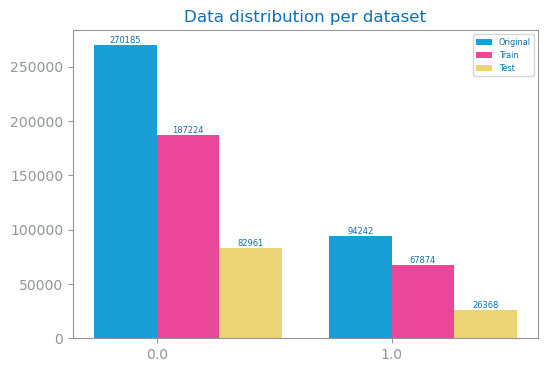

In [28]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from sklearn.model_selection import train_test_split
    from dslabs_functions import plot_multibar_chart

    # train/test split from DSLABS Classification/Evaluation Chapter
    # created split_data_save_csv on data_functions

    # Call the functions to split the data

    y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)

    train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")

## Scale 2 evaluate

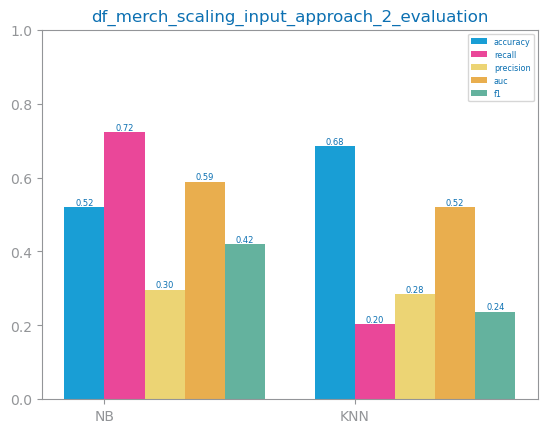

In [29]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='returning_user', metric="precision")
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_2_evaluation.png")
    show()

# scaling plot

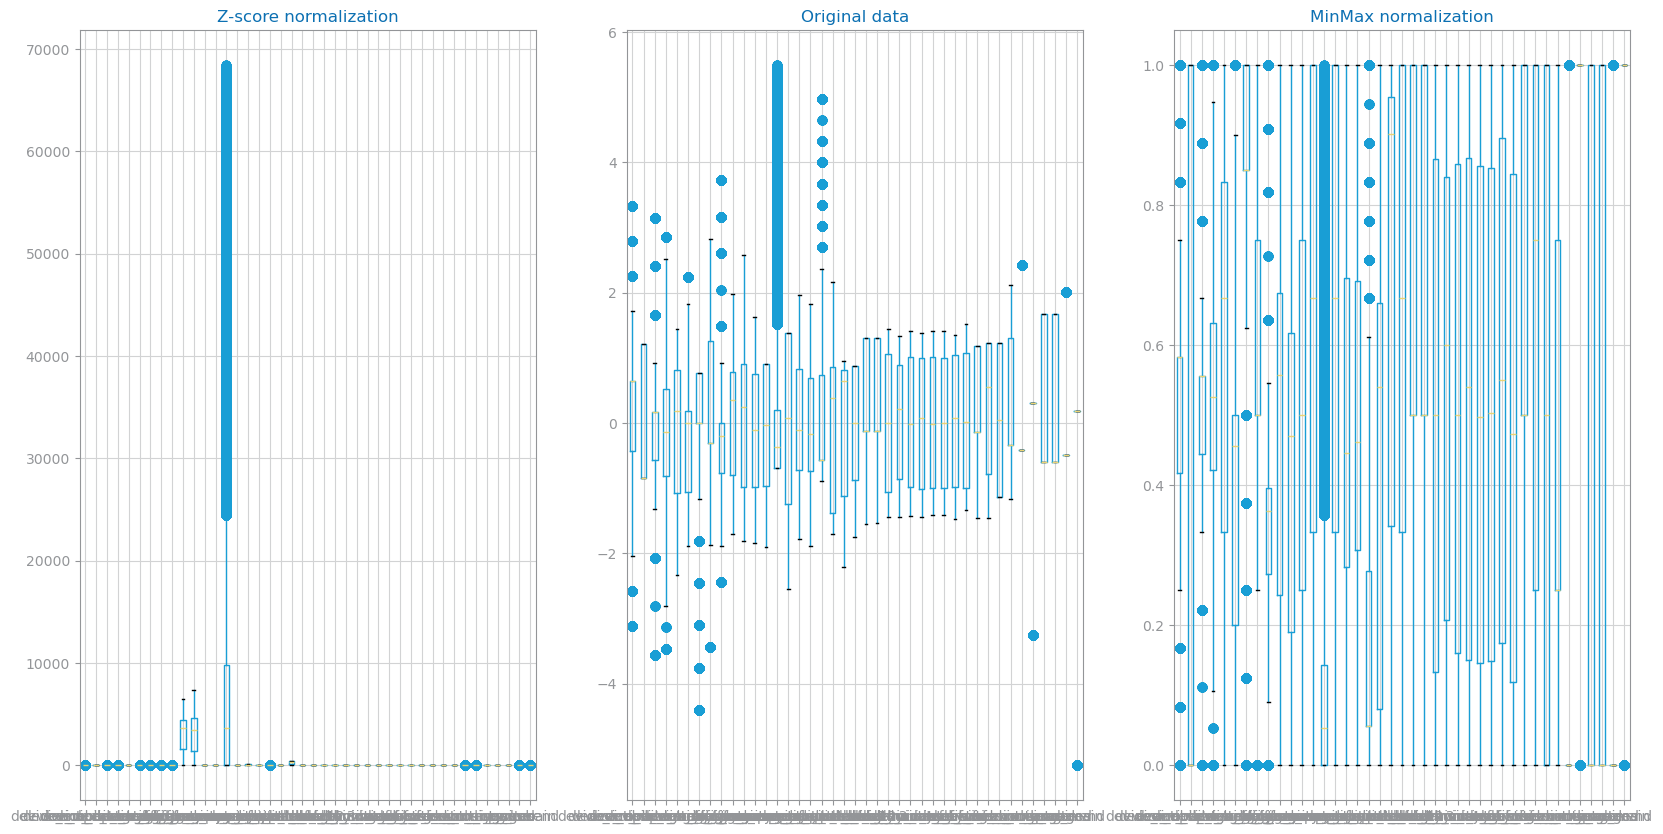

In [30]:
if evaluate == True:

    from matplotlib.pyplot import subplots, show

    fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
    axs[0, 1].set_title("Original data")
    data.boxplot(ax=axs[0, 0])

    axs[0, 0].set_title("Z-score normalization")
    data_1.boxplot(ax=axs[0, 1])

    axs[0, 2].set_title("MinMax normalization")
    data_2.boxplot(ax=axs[0, 2])
    show()

# Approach uplift comparison

## uplift df

In [31]:
if evaluate ==True:

    algorithms = ['Naive Bayes', 'KNN']

    # Create DataFrames for eval_1 and eval_2
    df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
    df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

    # Calculate uplift
    df_uplift = df_eval_2 - df_eval_1



    # Combine everything into one DataFrame (without misalignment issues)
    comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
    comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



    # Display the DataFrame
    display(comparison_df)

Approach 1                                         Approach 2  \
              accuracy    recall precision       auc        f1   accuracy   
Naive Bayes   0.519094  0.722201  0.296182  0.588370  0.420083   0.518929   
KNN           0.683588  0.214540  0.289524  0.523604  0.246455   0.684622   

                                                       Uplift            \
               recall precision       auc        f1  accuracy    recall   
Naive Bayes  0.722505  0.296149  0.588365  0.420102 -0.000165  0.000303   
KNN          0.203087  0.284507  0.520379  0.236999  0.001034 -0.011453   

                                           
            precision       auc        f1  
Naive Bayes -0.000032 -0.000005  0.000019  
KNN         -0.005016 -0.003225 -0.009455

# Analysis

- NB (better on approach 2): 
    - Scale1 accuracy 0.33, recall 0.87, auc 0.51
    - scale2 accuracy 0.43 recall 0.82, auc 0.56
- KNN: no significant uplifts between approaches
- overall scale 2 vs outliers treatment
    - very significant improved recall
    - significant accuracy loss


# save to csv

In [34]:
if test_data==False:
    

    data_save=data.copy()

    # apply winning strategy
    data_save=apply_strategy_1(data_save)
        
    data_save.to_csv(f"data/df_merch_5_scaler_input.csv", index=False)
    

    print(data_save.columns)

Index(['event_name', 'device_category', 'device_mobile_brand_name',
       'device_mobile_model_name', 'device_operating_system',
       'device_operating_system_version', 'device_language',
       'device_web_info_browser', 'device_web_info_browser_version',
       'geo_region', 'geo_city', 'traffic_source_medium',
       'traffic_source_source', 'engagement_time_msec', 'month', 'day_of_year',
       'week_number', 'page_path_level_1', 'page_path_level_2',
       'page_path_level_3', 'path_length', 'time_of_day_sin',
       'time_of_day_cos', 'local_hour_sin', 'local_hour_cos',
       'local_minute_sin', 'local_minute_cos', 'hour_minute_fraction_sin',
       'hour_minute_fraction_cos', 'day_sin', 'day_cos', 'day_of_week_nr_sin',
       'day_of_week_nr_cos', 'week_of_month_nr_sin', 'week_of_month_nr_cos',
       'geo_country', 'session_engaged', 'year', 'quarter', 'is_weekend',
       'domain', 'returning_user'],
      dtype='object')


## train test csv

In [35]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"data/df_merch_5_scaler_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"data/df_merch_5_scaler_input_test.csv", index=False)
    print(test.columns)

Labels=[0.0, 1.0]
Index(['event_name', 'device_category', 'device_mobile_brand_name',
       'device_mobile_model_name', 'device_operating_system',
       'device_operating_system_version', 'device_language',
       'device_web_info_browser', 'device_web_info_browser_version',
       'geo_region', 'geo_city', 'traffic_source_medium',
       'traffic_source_source', 'engagement_time_msec', 'month', 'day_of_year',
       'week_number', 'page_path_level_1', 'page_path_level_2',
       'page_path_level_3', 'path_length', 'time_of_day_sin',
       'time_of_day_cos', 'local_hour_sin', 'local_hour_cos',
       'local_minute_sin', 'local_minute_cos', 'hour_minute_fraction_sin',
       'hour_minute_fraction_cos', 'day_sin', 'day_cos', 'day_of_week_nr_sin',
       'day_of_week_nr_cos', 'week_of_month_nr_sin', 'week_of_month_nr_cos',
       'geo_country', 'session_engaged', 'year', 'quarter', 'is_weekend',
       'domain', 'returning_user'],
      dtype='object')
Index(['event_name', 'device_cate